# LSTM

In [1]:
from abc import ABC, abstractmethod
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Union
from IPython.display import HTML, clear_output
np.random.seed(42)

In [2]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./data/arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:128], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

In [3]:
tokens = list(set(''.join(lines)))

num_tokens = len(tokens)
print('num_tokens = ', num_tokens)

num_tokens =  136


In [4]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
token_to_id

{'k': 0,
 'W': 1,
 'Ł': 2,
 'Z': 3,
 '=': 4,
 '*': 5,
 'Σ': 6,
 'L': 7,
 '&': 8,
 'q': 9,
 'K': 10,
 'ó': 11,
 'g': 12,
 'ε': 13,
 '6': 14,
 ',': 15,
 '|': 16,
 'ã': 17,
 '5': 18,
 'ő': 19,
 'Q': 20,
 '$': 21,
 'J': 22,
 'i': 23,
 'σ': 24,
 'í': 25,
 'ρ': 26,
 'l': 27,
 'u': 28,
 '\x7f': 29,
 'P': 30,
 'Ö': 31,
 'm': 32,
 'a': 33,
 '\\': 34,
 'w': 35,
 'I': 36,
 '?': 37,
 'z': 38,
 '°': 39,
 '/': 40,
 '9': 41,
 'c': 42,
 'É': 43,
 '4': 44,
 'M': 45,
 '!': 46,
 'μ': 47,
 'á': 48,
 'à': 49,
 '{': 50,
 'V': 51,
 's': 52,
 ':': 53,
 'R': 54,
 '-': 55,
 'v': 56,
 'O': 57,
 '^': 58,
 '>': 59,
 '<': 60,
 'ô': 61,
 ';': 62,
 'x': 63,
 'ö': 64,
 'ê': 65,
 '2': 66,
 '(': 67,
 'n': 68,
 '+': 69,
 '`': 70,
 'E': 71,
 'y': 72,
 'λ': 73,
 'X': 74,
 'β': 75,
 ']': 76,
 ' ': 77,
 'Π': 78,
 'ü': 79,
 '\n': 80,
 '#': 81,
 'U': 82,
 '~': 83,
 'ç': 84,
 'S': 85,
 'ν': 86,
 'γ': 87,
 'F': 88,
 'Y': 89,
 'p': 90,
 'b': 91,
 'D': 92,
 'h': 93,
 ')': 94,
 'T': 95,
 '"': 96,
 'f': 97,
 'N': 98,
 '_': 99,
 'τ':

In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [6]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [7]:
print('\n'.join(lines[::2000]))
print(to_matrix(lines[::2000], token_to_id))

 Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layer

 Exploring Deep and Recurrent Architectures for Optimal Control ; Sophisticated multilayer neural networks have achieved state of

 Space and camera path reconstruction for omni-directional vision ; In this paper, we address the inverse problem of reconstructi

 Provable Algorithms for Inference in Topic Models ; Recently, there has been considerable progress on designing algorithms with 

 Fixing Weight Decay Regularization in Adam ; L$_2$ regularization and weight decay regularization are equivalent for standard st

 Query-Efficient Imitation Learning for End-to-End Autonomous Driving ; One way to approach end-to-end autonomous driving is to l

 Multiple Kernel Learning and Automatic Subspace Relevance Determination   for High-dimensional Neuroimaging Data ; Alzheimer's d

 A Search for Improved Performance in Regular Expressions ; The primary aim of auto

In [8]:
MAX_LENGTH = max(map(len, lines))
sample = to_matrix(np.random.choice(lines, size=5), token_to_id, max_len=MAX_LENGTH)

In [9]:
MAX_LENGTH

130

In [10]:
# dummy
encoded_data = np.zeros(shape=(5, MAX_LENGTH, len(token_to_id)))

for text_i, text in enumerate(encoded_data):
    for letter_i, letter in enumerate(text):
        encoded_data[text_i, letter_i, sample[text_i, letter_i]] = 1

encoded_data.shape

(5, 130, 136)

In [11]:
class BaseLayer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    def __call__(self, x: np.array, grad: bool = True) -> np.array:
        return self.forward(x, grad)

    @abstractmethod
    def forward(self, x: np.array, grad: bool = True) -> np.array:
        pass

    @abstractmethod
    def backward(self, output_error: np.array) -> np.array:
        pass


class Linear(BaseLayer):
    """
    Linear class permorms ordinary FC layer in neural networks
    Parameters:
    n_input - size of input neurons
    n_output - size of output neurons
    Methods:
    set_optimizer(optimizer) - is used for setting an optimizer for gradient descent
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, n_input: int, n_output: int) -> None:
        super().__init__()
        self.input = None
        self.n_input = n_input
        self.n_output = n_output
        self.w = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(n_input, n_output))
        self.b = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(1, n_output))

        self.w_optimizer = None
        self.b_optimizer = None

    def set_optimizer(self, optimizer) -> None:
        self.w_optimizer = copy.copy(optimizer)
        self.b_optimizer = copy.copy(optimizer)

        self.w_optimizer.set_weight(self.w)
        self.b_optimizer.set_weight(self.b)

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return x.dot(self.w) + self.b

    def backward(self, output_error: np.array) -> np.array:
        assert self.w_optimizer is not None and self.b_optimizer is not None, 'You should set an optimizer'
        w_grad = self.input.T.dot(output_error)
        b_grad = np.ones((1, len(output_error))).dot(output_error)
        input_error = output_error.dot(self.w.T)

        self.w = self.w_optimizer.step(w_grad)
        self.b = self.b_optimizer.step(b_grad)
        return input_error


class Activation(BaseLayer):
    """
    Activation class is used for activation function of the FC layer
    Params:
    activation_function - activation function (e.g. sigmoid, RElU, tanh)
    activation_derivative - derivative of the activation function
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, activation_function: callable, activation_derivative: callable) -> None:
        super().__init__()
        self.input = None
        self.activation = activation_function
        self.derivative = activation_derivative

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return self.activation(x)

    def backward(self, output_error: np.array) -> np.array:
        return output_error * self.derivative(self.input)

class BaseOptimizer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    @abstractmethod
    def set_weight(self, weight: np.array) -> None:
        pass

    @abstractmethod
    def step(self, grad: np.array) -> np.array:
        pass

class ADAM(BaseOptimizer):
    """
    Implements Adam algorithm.

    learning_rate (float, optional) – learning rate (default: 1e-3)
    beta1, beta2 (Tuple[float, float], optional) –
    coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    eps (float, optional) – term added to the denominator to improve numerical stability (default: 1e-8)
    """

    def __init__(self, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8,
                 learning_rate: float = 3e-4, weight_decay: float = 0) -> None:
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.EMA1 = None
        self.EMA2 = None

        self.weight = None

    def set_weight(self, weight: np.array) -> None:
        self.weight = weight.copy()
        self.EMA1 = np.zeros(shape=self.weight.shape)
        self.EMA2 = np.zeros(shape=self.weight.shape)

    def step(self, grad: np.array) -> np.array:
        assert self.weight is not None, 'You should set the weight'
        grad = grad.copy() + self.weight_decay * self.weight
        self.EMA1 = (1 - self.beta1) * grad + self.beta1 * self.EMA1
        self.EMA2 = (1 - self.beta2) * grad ** 2 + self.beta2 * self.EMA2
        self.weight -= self.learning_rate * self.EMA1 / (np.sqrt(self.EMA2) + self.eps)

        return self.weight.copy()

class Embedding(BaseLayer):
    def __init__(self, n_input, emb_dim, pad_idx=None):
        self.n_input = n_input
        self.emb_dim = emb_dim
        self.pad_idx = pad_idx
        
        self.weights = np.random.normal(scale=np.sqrt(2/(n_input+emb_dim)), size=(n_input, emb_dim))

    def set_optimizer(self, optimizer):
        self.weights_optimizer = copy.copy(optimizer)

        self.weights_optimizer.set_weight(self.weights)

    def forward(self, x, grad=True):
        self.input = x
        return self.weights[x]

    def backward(self, output_error):
        weights_grad = np.zeros_like(self.weights)
        input_shape_len = len(self.input.shape)

        if input_shape_len == 2:
            for batch_n, s in enumerate(self.input):
                for i, emb_i in enumerate(s):
                    weights_grad[emb_i] += output_error[batch_n][i]

        elif input_shape_len == 1:
            for i, emb_i in enumerate(self.input):
                weights_grad[emb_i] += output_error[i]

        if self.pad_idx is not None:
            weights_grad[self.pad_idx] = 0

        self.weights = self.weights_optimizer.step(weights_grad)

In [12]:
def tanh(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Tanh function
    """
    return np.tanh(z)

def tanh_derivative(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Tanh function derivative
    """
    return 1 - np.tanh(z) ** 2

def sigmoid(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Sigmoid function
    """
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Sigmoid function derivative
    """
    s = 1 / (1 + np.exp(-z))
    return s * (1 - s)

def softmax(z: np.array) -> np.array:
    """
    Softmax function
    """
    return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1, 1)

def cross_entropy_loss(y_true: np.array, a_pred: np.array) -> float:
    """
    CrossEntropyLoss for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: CrossEntropyLoss
    """
    lenght_y = list(range(len(y_true)))
    arg = -a_pred[lenght_y, y_true.ravel()]
    sum_exp = np.sum(np.exp(a_pred), axis=1)
    loss = np.sum(arg + np.log(sum_exp))
    return loss / len(y_true)

def cross_entropy_loss_derivative(y_true: np.array, a_pred: np.array) -> np.array:
    """
    CrossEntropyLoss derivative for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: np.array with shape [n_samples, n_classes] with CrossEntropyLoss derivatives for each weight
    """
    lenght_y = list(range(len(y_true)))
    sum_exp = np.sum(np.exp(a_pred), axis=1).reshape(-1, 1)
    loss = np.exp(a_pred.copy()) / sum_exp
    loss[lenght_y, y_true.ravel()] -= 1

    return loss / len(y_true)

![](./images/lstm.png)
![](./images/graph_meanings.png)

In [13]:
class LSTM:
    def __init__(
        self,
        n_input,
        n_hidden,
        n_output,
        bptt_trunc=4
    ):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.bptt_trunc = bptt_trunc
        
        self.forget_gate = Linear(n_input + n_hidden, n_hidden)
        self.forget_gate_activation = Activation(sigmoid, sigmoid_derivative)
        self.input_layer_gate = Linear(n_input + n_hidden, n_hidden)
        self.input_layer_gate_activation = Activation(sigmoid, sigmoid_derivative)
        self.candidate_gate = Linear(n_input + n_hidden, n_hidden)
        self.candidate_gate_activation = Activation(tanh, tanh_derivative)
        self.output_gate = Linear(n_input + n_hidden, n_hidden)
        self.output_gate_activation = Activation(sigmoid, sigmoid_derivative)
        self.output_to_logits = Linear(n_hidden, n_output)
        
        self.x_and_h = None
        self.hidden_states = None
        self.cell_states = None
        
        self.forget_inputs = None
        self.forget_states = None
        
        self.input_inputs = None
        self.input_states = None
        
        self.candidate_inputs = None
        self.candidate_states = None
        
        self.output_input = None
        self.output_states = None
        
        self.outputs = None
        
    def __call__(self, x):
        return self.forward(x)
    
    def set_optimizer(self, optimizer) -> None:
        self.forget_gate.set_optimizer(optimizer)
        self.input_layer_gate.set_optimizer(optimizer)
        self.candidate_gate.set_optimizer(optimizer)
        self.output_gate.set_optimizer(optimizer)
        self.output_to_logits.set_optimizer(optimizer)
        
    def forward(self, x):
        self.input = x
        batch_size, timesteps, input_dim = x.shape
        
        self.x_and_h = np.zeros((batch_size, timesteps, self.n_input+self.n_hidden))
        self.hidden_states = np.zeros((batch_size, timesteps+1, self.n_hidden))
        self.cell_states = np.zeros((batch_size, timesteps+1, self.n_hidden))
        
        self.forget_inputs = np.zeros((batch_size, timesteps, self.n_hidden))
        self.forget_states = np.zeros((batch_size, timesteps, self.n_hidden))
        
        self.input_inputs = np.zeros((batch_size, timesteps, self.n_hidden))
        self.input_states = np.zeros((batch_size, timesteps, self.n_hidden))
        
        self.candidate_inputs = np.zeros((batch_size, timesteps, self.n_hidden))
        self.candidate_states = np.zeros((batch_size, timesteps, self.n_hidden))
        
        self.output_input = np.zeros((batch_size, timesteps, self.n_hidden))
        self.output_states = np.zeros((batch_size, timesteps, self.n_hidden))
        
        self.outputs = np.zeros((batch_size, timesteps, self.n_output))

        self.hidden_states[:, -1] = np.zeros((batch_size, self.n_hidden))
        self.cell_states[:, -1] = np.zeros((batch_size, self.n_hidden))
        for t in range(timesteps):
            # соединяем вход и прошлый h
            self.x_and_h[:, t] = np.concatenate((x[:, t], self.hidden_states[:, t-1]), axis=1)
            
            # forget gate проход
            self.forget_inputs[:, t] = self.forget_gate(self.x_and_h[:, t])
            self.forget_states[:, t] = self.forget_gate_activation(self.forget_inputs[:, t])
            
            # выбор кандидатов для C
            self.input_inputs[:, t] = self.input_layer_gate(self.x_and_h[:, t])
            self.input_states[:, t] = self.input_layer_gate_activation(self.input_inputs[:, t])
            
            self.candidate_inputs[:, t] = self.candidate_gate(self.x_and_h[:, t])
            self.candidate_states[:, t] = self.candidate_gate_activation(self.candidate_inputs[:, t])
            
            self.cell_states[:, t] = self.forget_states[:, t] * self.cell_states[:, t-1]\
            + self.input_states[:, t] * self.candidate_states[:, t]
            
            self.output_input[:, t] = self.output_gate(self.x_and_h[:, t])
            self.output_states[:, t] = self.output_gate_activation(self.output_input[:, t])
            
            self.hidden_states[:, t] = self.output_states[:, t] * tanh(self.cell_states[:, t])
            
            # дополнительный слой, не указан на рисунке, для перевода состояния в логиты выхода
            self.outputs[:, t] = self.output_to_logits(self.hidden_states[:, t])

        return self.outputs
    
    def backward(self, output_error):        
        _, timesteps, _ = output_error.shape

        input_error = np.zeros_like(self.input)
        for t in np.arange(timesteps)[::-1]:
            # в разные моменты времени у слоев был разный вход, необходимо искусственно его поменять
            self.forget_gate.input = self.x_and_h[:, t]
            self.forget_gate_activation.input = self.forget_inputs[:, t]
            self.input_layer_gate.input = self.x_and_h[:, t]
            self.input_layer_gate_activation.input = self.input_inputs[:, t]
            self.candidate_gate.input = self.x_and_h[:, t]
            self.candidate_gate_activation.input = self.candidate_inputs[:, t]
            self.output_gate.input = self.x_and_h[:, t]
            self.output_gate_activation.input = self.output_input[:, t]
            self.output_to_logits.input = self.hidden_states[:, t]
            
            # проход по нижнему уровню
            hidden_error = self.output_to_logits.backward(output_error[:, t])
            # та, что идет вверх
            cell_error = tanh_derivative(self.cell_states[:, t]) * self.output_states[:, t] * hidden_error
            # ошибка идет и вниз и вверх
            hidden_error = self.output_gate_activation.backward(hidden_error) * tanh(self.cell_states[:, t])
            # та, что идет вниз
            hidden_error = self.output_gate.backward(hidden_error)

            
            # идем по верху
            hidden_candidate_error = self.candidate_gate_activation.backward(cell_error) * self.input_states[:, t]
            hidden_candidate_error = self.candidate_gate.backward(hidden_candidate_error)
            
            hidden_inputs_error = self.input_layer_gate_activation.backward(cell_error) * self.candidate_states[:, t]
            hidden_inputs_error = self.input_layer_gate.backward(hidden_inputs_error)
            
            hidden_forget_error = self.forget_gate_activation.backward(cell_error) * self.cell_states[:, t-1]
            hidden_forget_error = self.forget_gate.backward(hidden_forget_error)
            
            # добавляются ошибки с мест копии
            hidden_error += hidden_candidate_error
            hidden_error += hidden_inputs_error
            hidden_error += hidden_forget_error

            # ошибка входа
            input_error[:, t] = hidden_error[:, :self.n_input]
            # ошибка, которая по времени уходит по низу назад
            hidden_error = hidden_error[:, self.n_input:]
            # ошибка, которая по времени уходит по верху назад
            cell_error = cell_error * self.forget_states[:, t]
            
            for t_ in np.arange(max(0, t - self.bptt_trunc), t)[::-1]:
                # проход по времени
                self.forget_gate.input = self.x_and_h[:, t_]
                self.forget_gate_activation.input = self.forget_inputs[:, t_]
                self.input_layer_gate.input = self.x_and_h[:, t_]
                self.input_layer_gate_activation.input = self.input_inputs[:, t_]
                self.candidate_gate.input = self.x_and_h[:, t_]
                self.candidate_gate_activation.input = self.candidate_inputs[:, t_]
                self.output_gate.input = self.x_and_h[:, t_]
                self.output_gate_activation.input = self.output_input[:, t_]
                
                # та, что идет по верху
                cell_error += tanh_derivative(self.cell_states[:, t_]) * self.output_states[:, t_]\
                * hidden_error
                
                hidden_error = self.output_gate_activation.backward(hidden_error) * tanh(self.cell_states[:, t_])
                # та, что идет вниз
                hidden_error = self.output_gate.backward(hidden_error)
                
                hidden_candidate_error = self.candidate_gate_activation.backward(cell_error) * self.input_states[:, t_]
                hidden_candidate_error = self.candidate_gate.backward(hidden_candidate_error)

                hidden_inputs_error = self.input_layer_gate_activation.backward(cell_error) * self.candidate_states[:, t_]
                hidden_inputs_error = self.input_layer_gate.backward(hidden_inputs_error)

                hidden_forget_error = self.forget_gate_activation.backward(cell_error) * self.cell_states[:, t_-1]
                hidden_forget_error = self.forget_gate.backward(hidden_forget_error)
                
                # добавляются ошибки с мест копии
                hidden_error += hidden_candidate_error
                hidden_error += hidden_inputs_error
                hidden_error += hidden_forget_error

                # ошибка которая по времени уходит по низу назад
                hidden_error = hidden_error[:, self.n_input:]
                cell_error = cell_error * self.forget_states[:, t_]

        return input_error

![](./images/lstm_output.png)

In [14]:
emb_size = 16
emb = Embedding(len(token_to_id), emb_size)

encoded_data = emb(sample)
print(encoded_data.shape)

lstm_unit = LSTM(n_input=emb_size,
                 n_hidden=64,
                 n_output=len(token_to_id),
                 bptt_trunc=15)

lstm_unit.set_optimizer(ADAM())

(5, 130, 16)


In [15]:
lstm_unit.forward(encoded_data).shape

(5, 130, 136)

In [16]:
pred = lstm_unit(encoded_data)

loss = 0
for t in range(sample.shape[1]-1):
    loss += cross_entropy_loss(sample[:, t+1].reshape(-1, 1), pred[:, t, :])

errors = np.zeros(shape=(5, MAX_LENGTH-1, len(token_to_id)))
for t in range(errors.shape[1]-1):
    errors[:, t, :] = cross_entropy_loss_derivative(sample[:, t+1].reshape(-1, 1), pred[:, t, :])

lstm_unit.backward(errors)

array([[[-1.95990624e-02, -9.71520632e-03,  3.34700326e-03, ...,
          1.30230343e-02, -4.77261659e-02, -1.53955901e-03],
        [-1.03271889e-01, -4.96441055e-02,  6.23509224e-02, ...,
          1.02424136e-01, -2.84650669e-01,  1.68562749e-02],
        [-5.28707830e-03,  9.32539449e-04,  9.54039307e-03, ...,
          3.12340121e-03, -1.78017845e-03,  4.16816201e-03],
        ...,
        [-2.81297753e-03, -2.11667539e-03, -1.76698838e-03, ...,
         -3.55162981e-03,  2.54524700e-03, -5.26920082e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-2.92847507e-02, -1.74590173e-02,  1.85815298e-02, ...,
          1.77227756e-02, -6.94293749e-02, -7.26623039e-04],
        [-1.03473049e-01, -5.61172971e-02,  5.58972278e-02, ...,
          1.04822190e-01, -3.03586503e

In [17]:
lines

[' Dual Recurrent Attention Units for Visual Question Answering ; We propose an architecture for VQA which utilizes recurrent layer\n',
 ' Sequential Short-Text Classification with Recurrent and Convolutional   Neural Networks ; Recent approaches based on artificial \n',
 ' Multiresolution Recurrent Neural Networks: An Application to Dialogue   Response Generation ; We introduce the multiresolution r\n',
 ' Learning what to share between loosely related tasks ; Multi-task learning is motivated by the observation that humans bring to \n',
 ' A Deep Reinforcement Learning Chatbot ; We present MILABOT: a deep reinforcement learning chatbot developed by the Montreal Inst\n',
 ' Generating Sentences by Editing Prototypes ; We propose a new generative model of sentences that first samples a prototype sente\n',
 ' A Deep Reinforcement Learning Chatbot (Short Version) ; We present MILABOT: a deep reinforcement learning chatbot developed by t\n',
 ' Document Image Coding and Clustering for Scri

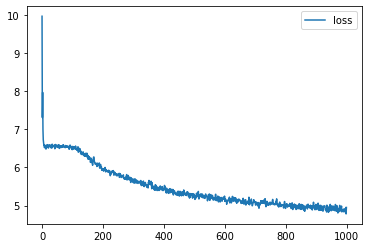

In [18]:
emb_size = 16
emb = Embedding(len(token_to_id), emb_size)
emb.set_optimizer(ADAM(learning_rate=0.0001))

lstm_unit = LSTM(
    n_input=emb_size,
    n_hidden=64,
    n_output=len(token_to_id),
    bptt_trunc=15
)
lstm_unit.set_optimizer(ADAM(learning_rate=0.0001))

batch_size = 64
history = []
for i in range(1000):
    batch_ix = to_matrix(np.random.choice(lines, size=batch_size, replace=False), token_to_id, max_len=MAX_LENGTH)
    
    encoded_data = emb(batch_ix)
    
    pred = lstm_unit(encoded_data)

    loss = 0
    for t in range(batch_ix.shape[1]-1):
        loss += cross_entropy_loss(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
        
    errors = np.zeros(shape=(batch_size, MAX_LENGTH-1, len(token_to_id)))
    for t in range(errors.shape[1]-1):
        errors[:, t, :] = cross_entropy_loss_derivative(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
    
    err = lstm_unit.backward(errors)
    emb.backward(err)
    
    # visualizing training process
    history.append(loss / batch_size)
    if (i + 1) % 10 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [19]:
history[-1]

4.94967026594122

In [20]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    phrase = copy.copy(seed_phrase)
    
    for t in range(len(seed_phrase)-1, max_length-len(seed_phrase)):
        x_sequence = to_matrix([phrase], token_to_id, max_len=max_length)
        encoded_data = emb(x_sequence)

        pred = char_rnn(encoded_data)
        probs = softmax(pred[:, t] / temperature).ravel()
        next_ix = np.random.choice(len(tokens), p=probs)
        phrase += tokens[next_ix]
    return phrase

In [21]:
for _ in range(10):
    print(generate_sample(lstm_unit, seed_phrase=' ', temperature=0.5))

 On A intione ; Dearnion ; The teprof tion an ; Antion in in ; Lece on ert a A A pro trol Re wor on iopror Ses ; The Pransing semt
 Stion of Tineror Lamwor anent ;  al Recing  Ere tore The Eve ering ; in the ose The of on ; Mope ; A int sure wert tor Prork in o
 A Rusent oning Alising an ale on arion ; Qontal sertion of Teruss for Pror Are are tesure sining ; Mear ion ; Corsing ; cons or P
 Delin   Lovic bisitionion of Sesianing ; Aatif End intion Lide Prol seralliving ; ders tor ; Moprol sering Dearsical Aution ; in 
 A tor Artion for Leltion of Afal corpror  pers ; pre are Nody bericis Core pere ; ; The of Fecar in in   Pres ; Mualtion or Sine 
 Meral A aling Seer A Bo ere fove wor   Momere tre In ; Neere tectes ; caped and on ; on on or Talting ; Araling of for   Ness ; A
 Rearne misice ; Meuwes in lise pre o pro mor Contion tre ; Aert con sertion of Ses sice Aution aning Ler pre   Ses Reming the ; A
 Ferien Cers ( fetwof des ; A pre In an are Mase Aluer of Deersing on for Cor ors ;

In [22]:
lstm_unit(encoded_data)[1].argmax(axis=1)

array([121, 130, 130, 131,  68,  27,  23, 113, 132,  23,  23, 131,  68,
       132,  77,  62, 130, 131, 130, 113,  77, 131,  77, 130,  77,  77,
        23,  77, 132,  77,  62,  68, 131,  68,  12,  77,  62, 131, 130,
       130, 130, 113, 113,  68,  77,  23, 130,  77, 132,  23, 113,  68,
        77,  27,  77,  62, 131,  42, 130, 131,  27,  77,  62, 131,  42,
        23, 113, 130,  77,  77,  77,  62,  77,  95, 131, 131, 130,  77,
        77,  77,  27,  77,  62, 131, 130,  52,  77,  62,  68,  77,  77,
       113,  68,  77,  77,  77,  77,  77,  23,  77, 132,  77,  62,  68,
        77,  62,  68, 121, 113, 130,  90,  23, 130,  77, 113, 113, 131,
        68,  12,  68,  23, 132,  77,  33, 130, 113, 132, 131,  23,  77],
      dtype=int64)

In [23]:
batch_ix[1, 1:]

array([ 30, 131, 106,  23,  33, 132, 130,  23,  42,  77, 122, 113,  68,
       131,  77, 121,  12, 131,  77, 121,  52,  52, 131,  52,  52,  32,
       131,  68, 132,  77,  82,  52,  23,  68,  12,  77,  92, 131, 131,
        90,  77, 103, 113,  68,  56, 113,  27,  28, 132,  23, 113,  68,
        33,  27,  77,  98, 131,  28, 130,  33,  27,  77,  98, 131, 132,
        35, 113, 130,   0,  52,  77,  62,  77,  85,   0, 131,  27, 131,
       132,  33,  27,  77,  91, 113,  68, 131,  77,  33,  12, 131,  77,
        33,  52,  52, 131,  52,  52,  32, 131,  68, 132,  77,  23,  52,
        77,  33,  77,  42, 113,  32,  32, 113,  68,  77,  42,  27,  23,
        68,  23,  42,  33,  27,  77,  90, 130,  33,  42, 132,  80])

In [24]:
with open('./style.css') as f:
    style = f.read()
HTML(style)